# Pima Indians Diabetes Project
The goal of this project is to practice data preprocessing, implement multiple
classification algorithms, and evaluate models using different metrics. 
The `diabetes` dataset contains independent variables, which are different factors that 
could potentially cause diabetes, and dependent variable, which is whether the individual has
the diabetes or not. One thing to note is that all patients in this dataset are females
at least 21 years old of Pima Indian Heritage.

This notebook presents the process of exploring the dataset and selecting features for modeling. Next notebook contains the process for modeling and model evaluation using different metrics.

In [1]:
# data analysis, wrangling and preprocessing
import numpy as np 
import pandas as pd
import random

# statistical analysis
from scipy import stats

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# statistical modeling
import statsmodels.api as sm 

# feature selection
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

## Loading Data
We start by loading the dataset into Pandas DataFrames.

In [2]:
diabetes = pd.read_csv('diabetes.csv')
diabetes.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

Here is a brief description of each column:
* `Pregnancies`: number of times pregnant
* `Glucose`: blood plasma glucose concentration a 2 hours in an oral glucose tolerance test
* `BloodPressure` : Diastolic blood pressure with a unit of  mm Hg
* `SkinThickness` : triceps skin fold thickness with a unit of mm
* `Insulin` : 2-Hour serum insulin with a unit of mu U/ml
* `BMI` : body mass index, which is calculated by weight in kg/(height in m)^2
* `DiabetesPedigreeFunction` : a synthesis of the diabetes mellitus history in relatives 
and the genetic relationship of those relatives to the subject
* `Age` : age of the patient in years
* `Outcome` : whether the patient has diabetes or not, which is our target variable that we are trying 
to predict

## Exploratory Data Analysis
We use exploratory data analysis (EDA) to identify irregularities, patterns and possible relationships
between variables within the given dataset. If helps us determine variables that we could use 
in our models and identify what preprocessing steps we have to do before putting them into the model.
* We will start off with **univariate analysis**, planning to understand the distribution of the
underlying variable individually. During this process, we can identify if there are any outliers or other 
abnormalies we have to deal with before putting the data into the models.
* Next, we will perform **missingness analysis** where we identify potential missing values in this dataset and use statistical testing to determine whether the missingness are dependent.
* Then, we will conduct **bivariate analysis** between the variable and the target variable to see how the variable affects the dependent variable.

Using the info function to check if there is any missing values in this dataset. 

In [3]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


There is no NaNs in the `diabetes` dataset. However, we will dig into each column to determine whether 
all data points are valid and not just missing values fill in with zeros.

All the data types are correct.

### Examine the distribution of the `Outcome` column (the target variable)
Let's start this analysis by looking at the distribution of the target variable and check
if the targets are evenly distributed.

In [4]:
diabetes['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

We have noticed that our target variable is not evenly distributed, which means we have to stratify 
the target variable when we split the data into training and testing datasets for models that not account
for the difference in the underlying distribution. 

### Examine the distribution of `Pregnancies` column
We want to see the distribution of `Pregnancies` column and check if all of the values are reasonable.

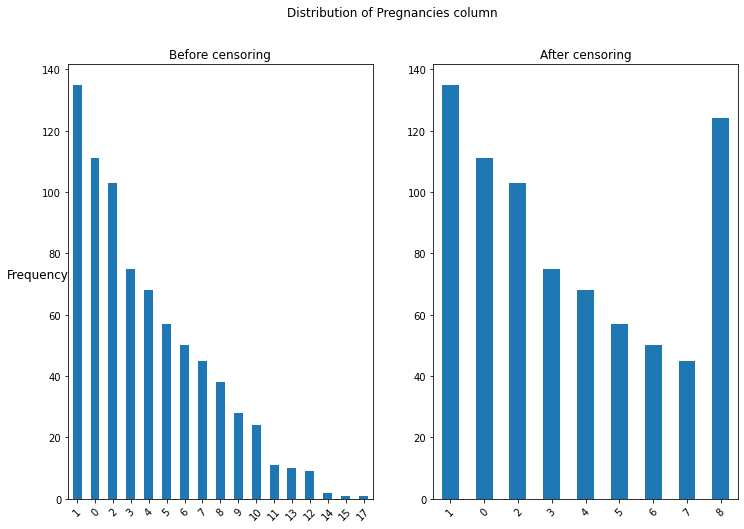

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
fig.suptitle('Distribution of Pregnancies column')
df = pd.DataFrame(diabetes['Pregnancies'].value_counts())
df.plot(kind='bar', legend=None, ax=axes[0])
plt.xticks(rotation=45)
df1 = pd.DataFrame(diabetes['Pregnancies'].value_counts())
df1.loc[8] = df1[df1.index >= 8].Pregnancies.sum()
df1.drop(index=[9,10,11,12,13,14,15,17],inplace=True)
df1.plot(kind='bar', legend=None, ax=axes[1])
plt.xticks(rotation=45)
cols = ['Before censoring', 'After censoring']
rows = ['Frequency']

for ax, col in zip(axes, cols):
    ax.set_title(col)
for ax, row in zip(axes, rows):
    ax.set_ylabel(row, rotation=0, size='large')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

As you can see on the left distribution plot above, cases where people in this dataset who are 
pregnant 8 times. Also, it's unusual for people to get pregnant more than
8 times in real life. As a result, we set the values above 8 to be 8. 

### Examine the distribution of `Glucose` column 
We would like to see the distribution of `Glucose` column.

Text(0.5, 1.0, 'Density Plot of Glucose column')

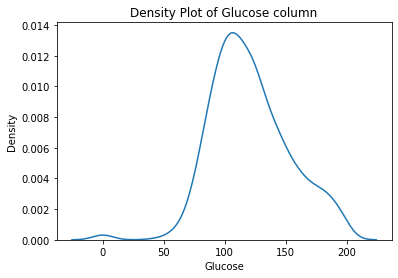

In [6]:
sns.kdeplot(diabetes['Glucose'])
plt.title('Density Plot of Glucose column')

The distribution of `Glucose` column is roughly normally distribution. We can notice there are several
records with values of 0. We want to look more deeply into those records:

In [7]:
zero_glucose = diabetes[diabetes['Glucose'] == 0].shape[0]
zero_glucose_outcome = diabetes[diabetes['Glucose'] == 0].Outcome.mean()
nonzero_glucose_outcome = round(diabetes[diabetes['Glucose'] != 0].Outcome.mean(), 2)
print(f'There are {zero_glucose} records with glucose of zero. \
\nThe rows where glucose are zero have a mean outcome of {zero_glucose_outcome}\
\nThe rows where glucose are non-zero have a mean outcome of {nonzero_glucose_outcome}')

There are 5 records with glucose of zero. 
The rows where glucose are zero have a mean outcome of 0.4
The rows where glucose are non-zero have a mean outcome of 0.35


In [8]:
i = diabetes[diabetes['Glucose'] == 0].index
diabetes.drop(i, inplace = True)

Since there are only 5 records with glucose of zero, which is less than 1% of the records in this
dataset, and there is not much of a significance between records where glucose of zero and 
non-zero. We decided to drop these records.

### Examine the distribution of `BloodPressure` column 
We want to explore the underlying distribution of `BloodPressure` column and see if there are 
any outliers.

Text(0.5, 1.0, 'Density plot of BloodPressure column')

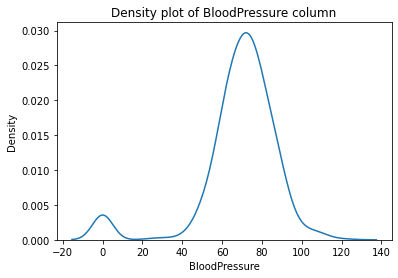

In [9]:
sns.kdeplot(diabetes['BloodPressure'])
plt.title('Density plot of BloodPressure column')

According to the density plot above, most of the patient in the `diabetes` dataset have their
blood pressure around 70. We also notice that there are some patients that have blood pressure
of zeros, which are not possible. We see them as missing values. 

### Examine the distribution of `SkinThickness` column
We want to investigate the underlying distribution of `SkinThickness` column and check if there are 
any abnormalities.

Text(0.5, 1.0, 'Histogram of SkinThickness column')

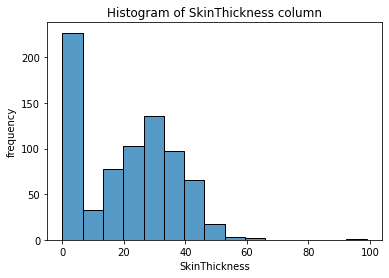

In [10]:
sns.histplot(diabetes['SkinThickness'])
plt.ylabel('frequency')
plt.title('Histogram of SkinThickness column')

According to the histogram above, over 200 records have `SkinThickness` to be zero, 
which is not normal.
As a result, we look deeper into this particular measurement. 
* Skinfold thickness measure subcutaneous body fat. 
* The standard normal values for triceps skinfolds are 2.5mm (men) or about 
20% fat; 18.0mm (women) or about 30% fat. 
* Values over 20mm (men) and 30mm (women) represent about the 85th percentile, 
and can be considered as obese. 

source: Table formulated by Body Composition laboratory at Monash Medical Centre 
using the Durnin & Womesley equation

It is not possible that over 200 records have `Skinthickness` to be zero. 
They are most likely are missing values that we have to deal with. 

Text(0.5, 1.0, 'Histogram of SkinThickness column without zero record')

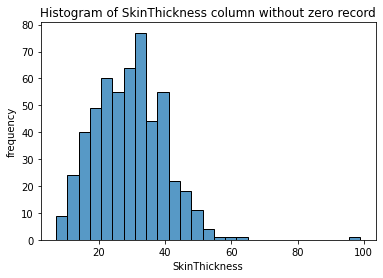

In [11]:
sns.histplot(diabetes[diabetes['SkinThickness'] != 0].SkinThickness)
plt.ylabel('frequency')
plt.title('Histogram of SkinThickness column without zero record')

It seems like the distribution of `SkinThickness` withouth zero values are normally distribution. But,
we have to use hypothesis testing to check. If it's normally distributed, we can replace the zeros with 
the mean of the normal distribution.

In [12]:
k2, p = stats.normaltest(diabetes[diabetes['SkinThickness'] != 0].SkinThickness)
alpha = 0.05
print("p = {:g}".format(p))
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("Reject null")
else:
    print("Fail to reject null")

p = 1.07997e-17
Reject null


Since the distribution of `SkinThickness` without missing value is not normally distributed, 
we have to find other ways to deal with the missing values, such as using a model with other 
variables to predict the missing data in this column or just randomly impute existing values.

### Examine the distribution of `Insulin` column
We want to examine the distribution of `Insulin` column to see if there is any irregularities.

Text(0.5, 1.0, 'Histogram of Insulin column')

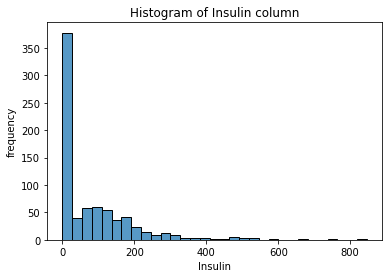

In [13]:
sns.histplot(diabetes['Insulin'])
plt.ylabel('frequency')
plt.title('Histogram of Insulin column')

In [14]:
zero_insulin = diabetes[diabetes['Insulin'] == 0].shape[0]
zero_insulin_percentage = round(zero_insulin / diabetes.shape[0], 2) * 100
print(f'{zero_insulin_percentage}% of the records with insulin of zero.')

48.0% of the records with insulin of zero.


Since almost half of the data in the `Insulin` column are zeros, it will certainly mess up 
our predictive models. We will see what are the differences between other numerical columns 
for rows where `Insulin` is zero and those that are not.

### Examine the distribution of `BMI` column
We want to investigate the distribution of `BMI` column as it provides some ideas about the weight condition
of a particular patient. 

Text(0.5, 1.0, 'Density of BMI column')

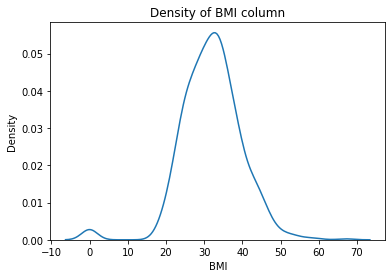

In [15]:
sns.kdeplot(diabetes['BMI'])
plt.title('Density of BMI column')

Based on the density plot above, most of the BMI lies in the the range between 20 and 50. 
It's not possible to have zero BMIs. And we can assume that those are missing values.

In [16]:
i = diabetes[diabetes['BMI'] == 0].index
diabetes.drop(i, inplace = True)

Since the percentage of missing values in this column is small. We decided to just
drop those columns.

### Examine the distribution of `DiabetesPedigreeFunction`
We want to investigate the distribution of `DiabetesPredigreeFunction` column.

Text(0.5, 1.0, 'Histogram of DiabetesPedigreeFunction column')

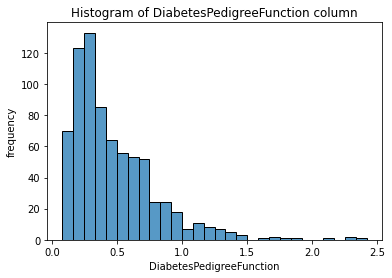

In [17]:
sns.histplot(diabetes['DiabetesPedigreeFunction'])
plt.ylabel('frequency')
plt.title('Histogram of DiabetesPedigreeFunction column')

The distribution for this column is right skewed with the peak at around 0.25. 
This can be intepreted as the likelihood of most records in this dataset to have diabetes 
based on their known family history is 25 percent. Also, most records lie in below 0.5. 

Text(0.5, 1.0, 'Histogram of DiabetesPedigreeFunction column without zero')

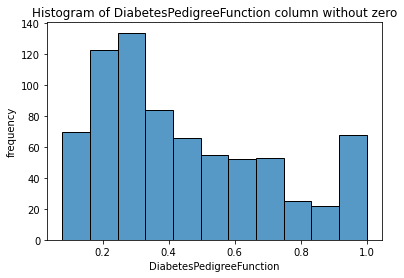

In [18]:
diabetes['DiabetesPedigreeFunction'] = np.where(diabetes['DiabetesPedigreeFunction'] > 1.0, 1.0, diabetes['DiabetesPedigreeFunction'])
sns.histplot(diabetes['DiabetesPedigreeFunction'])
plt.ylabel('frequency')
plt.title('Histogram of DiabetesPedigreeFunction column without zero')

As a refresher, `DiabetesPedigreeFunction` is the result of a function that scores the 
likelihood of diabetes based on family history. The things to note here is that there are 
values that are greater than 1.0, which is not possible because the function produces a 
probability. As a result, it makes sense to censor the data above 1.0.

The histogram above the resulting distribution after censoring.

### Examine the distribution of the `Age` column
We want to investigate the distribution of `Age` column to see how well every age group is 
represented in this dataset.

Text(0.5, 1.0, 'Histogram of Age column')

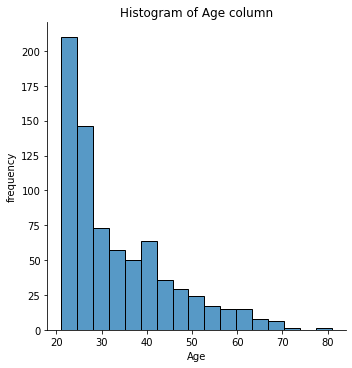

In [19]:
sns.displot(diabetes['Age'])
plt.ylabel('frequency')
plt.title('Histogram of Age column')

Due to the sampling bias, `Age` column reflects that this dataset only contain people who are 
more than 21-year-old. The sensoring of the data is a potential issue result from the 
limitation of this dataset. It means the sample we have is not representative for the whole 
population as it only has data available for women above age of 21. If we can somehow acquire 
data that is more representative, we are able to build a model that can help classify whether 
the patient from a larger group of people has diabetes.

Takeaways and things to address from the **univariate analysis** above:
* 28 missing values in the `BloodPressure` column
* Over 200 missing values in the `SkinThickness` column
* 48% of the values are missing in the `Insulin` column

Next, we want to conduct missiness analysis on those three particular columns.

### Investigate the difference in the distributions between numerical columns with `BloodPressure` of zero and those that are not 
In order to avoid the confounding variables that could have a influence in the distribution, we decided to 
create masks for the purpose of filtering.

In [20]:
no_bp = ( diabetes.BloodPressure == 0 )
no_skin = (diabetes.SkinThickness == 0 )
no_insulin = (diabetes.Insulin == 0)

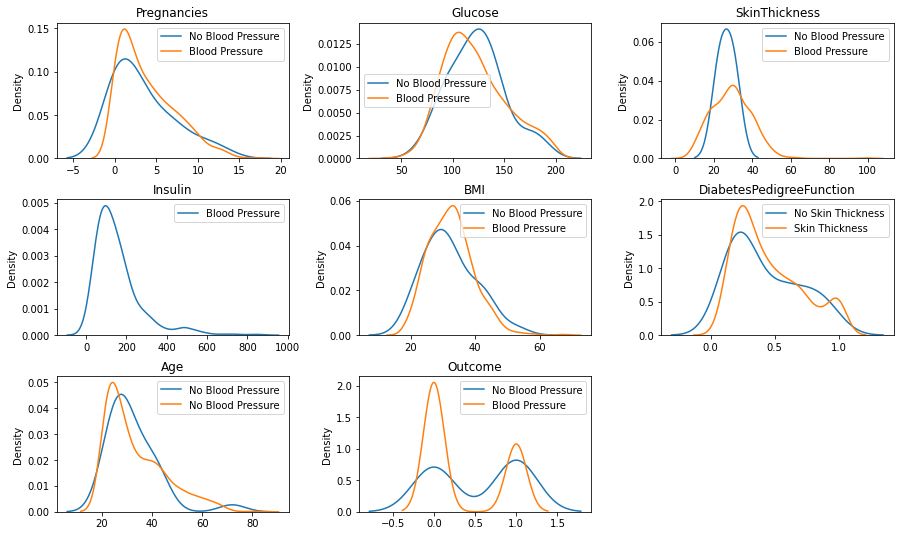

In [21]:
fig, axs = plt.subplots(3, 3, figsize=(15,9))

sns.kdeplot(diabetes[ no_bp ].Pregnancies, label='No Blood Pressure', ax = axs[0,0])
sns.kdeplot(diabetes[ ~no_bp ].Pregnancies, label='Blood Pressure', ax = axs[0,0] )
axs[0,0].set_title('Pregnancies')
axs[0,0].legend()
axs[0,0].xaxis.label.set_visible(False)

sns.kdeplot(diabetes[ (no_bp) ].Glucose, label='No Blood Pressure', ax = axs[0,1])
sns.kdeplot(diabetes[ (~no_bp) ].Glucose, label='Blood Pressure', ax = axs[0,1])
axs[0,1].set_title('Glucose')
axs[0,1].legend()
axs[0,1].xaxis.label.set_visible(False)

sns.kdeplot(diabetes[ (no_bp) & (~no_skin) ].SkinThickness, label='No Blood Pressure', ax = axs[0,2])
sns.kdeplot(diabetes[ (~no_bp) & (~no_skin) ].SkinThickness, label='Blood Pressure', ax = axs[0,2])
axs[0,2].set_title('SkinThickness')
axs[0,2].legend()
axs[0,2].xaxis.label.set_visible(False)

sns.kdeplot(diabetes[ (no_bp) & (~no_insulin) ].Insulin, label='No Blood Pressure', ax = axs[1,0])
sns.kdeplot(diabetes[ (~no_bp) & (~no_insulin) ].Insulin, label='Blood Pressure', ax = axs[1,0])
axs[1,0].set_title('Insulin')
axs[1,0].legend()
axs[1,0].xaxis.label.set_visible(False)

sns.kdeplot(diabetes[ no_bp ].BMI, label='No Blood Pressure', ax = axs[1,1])
sns.kdeplot(diabetes[ ~no_bp ].BMI, label='Blood Pressure', ax = axs[1,1])
axs[1,1].set_title('BMI')
axs[1,1].legend()
axs[1,1].xaxis.label.set_visible(False)

sns.kdeplot(diabetes[ no_bp ].DiabetesPedigreeFunction, label='No Skin Thickness', ax = axs[1,2])
sns.kdeplot(diabetes[ ~no_bp ].DiabetesPedigreeFunction, label='Skin Thickness', ax = axs[1,2])
axs[1,2].set_title('DiabetesPedigreeFunction')
axs[1,2].legend()
axs[1,2].xaxis.label.set_visible(False)

sns.kdeplot(diabetes[ no_bp ].Age, label='No Blood Pressure', ax = axs[2,0])
sns.kdeplot(diabetes[ ~no_bp ].Age, label='No Blood Pressure', ax = axs[2,0])
axs[2,0].set_title('Age')
axs[2,0].legend()
axs[2,0].xaxis.label.set_visible(False)

sns.kdeplot(diabetes[ no_bp ].Outcome, label='No Blood Pressure', ax = axs[2,1])
sns.kdeplot(diabetes[ ~no_bp ].Outcome, label='Blood Pressure', ax = axs[2,1])
axs[2,1].set_title('Outcome')
axs[2,1].legend()
axs[2,1].xaxis.label.set_visible(False)

axs[2,2].remove()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)

Some key takeaways from the plot above: 
* There are not much of a differences between the distributions of `BloodPressure` of zeros and those that
are not for these columns: `Glucose`,`BMI`, `DiabetesPredigreeFunction`, and `Age`.
* The distribution of `Pregnancies` is more dense at around 0 for people with `BloodPressure`.
* `SkinThickess` is more likely to be around 20 for people without `BloodPressure` data that are available
to us.
* People without `BloodPressure` data that are available to us seem to be missing data from the `Insulin`
column as well.
* People with blood pressure data that are available to us have an unbalance distribution in `Outcome`. 
However, we can also see that people with blood pressure data that are not available to us have an even distribution amoung `Outcome`.

We decided to handle missing values by imputing existing values in that column randomly. We will use the same method to treat any columns with large amount of missing vlaues. 

In [22]:
diabetes['BloodPressure']=diabetes['BloodPressure'].replace(0, random.choice(diabetes[diabetes.BloodPressure != 0 ]["BloodPressure"]))

### Investigate the difference in the distributions between numerical columns with `SkinThickness` of zero and those that are not 
We repeat the same analysis for `BloodPressure` we did with `SkinThickness`. 

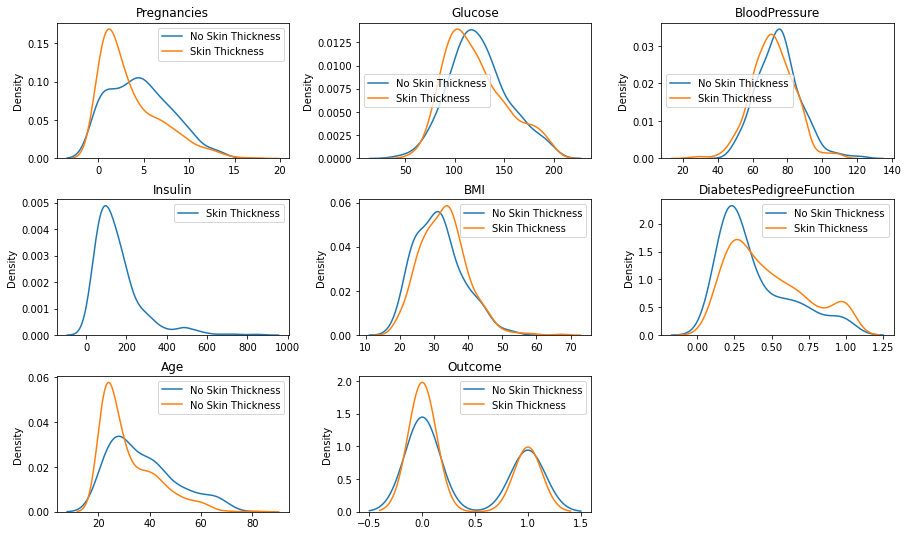

In [23]:
fig, axs = plt.subplots(3, 3, figsize=(15,9))

sns.kdeplot(diabetes[ no_skin ].Pregnancies, label='No Skin Thickness', ax = axs[0,0])
sns.kdeplot(diabetes[ ~no_skin ].Pregnancies, label='Skin Thickness', ax = axs[0,0] )
axs[0,0].set_title('Pregnancies')
axs[0,0].legend()
axs[0,0].xaxis.label.set_visible(False)

sns.kdeplot(diabetes[ (no_skin) ].Glucose, label='No Skin Thickness', ax = axs[0,1])
sns.kdeplot(diabetes[ (~no_skin) ].Glucose, label='Skin Thickness', ax = axs[0,1])
axs[0,1].set_title('Glucose')
axs[0,1].legend()
axs[0,1].xaxis.label.set_visible(False)

sns.kdeplot(diabetes[ (no_skin) & (~no_bp) ].BloodPressure, label='No Skin Thickness', ax = axs[0,2])
sns.kdeplot(diabetes[ (~no_skin) & (~no_bp) ].BloodPressure, label='Skin Thickness', ax = axs[0,2])
axs[0,2].set_title('BloodPressure')
axs[0,2].legend()
axs[0,2].xaxis.label.set_visible(False)

sns.kdeplot(diabetes[ (no_skin) & (~no_insulin) ].Insulin, label='No Skin Thickness', ax = axs[1,0])
sns.kdeplot(diabetes[ (~no_skin) & (~no_insulin) ].Insulin, label='Skin Thickness', ax = axs[1,0])
axs[1,0].set_title('Insulin')
axs[1,0].legend()
axs[1,0].xaxis.label.set_visible(False)

sns.kdeplot(diabetes[ no_skin ].BMI, label='No Skin Thickness', ax = axs[1,1])
sns.kdeplot(diabetes[ ~no_skin ].BMI, label='Skin Thickness', ax = axs[1,1])
axs[1,1].set_title('BMI')
axs[1,1].legend()
axs[1,1].xaxis.label.set_visible(False)

sns.kdeplot(diabetes[ no_skin ].DiabetesPedigreeFunction, label='No Skin Thickness', ax = axs[1,2])
sns.kdeplot(diabetes[ ~no_skin ].DiabetesPedigreeFunction, label='Skin Thickness', ax = axs[1,2])
axs[1,2].set_title('DiabetesPedigreeFunction')
axs[1,2].legend()
axs[1,2].xaxis.label.set_visible(False)

sns.kdeplot(diabetes[ no_skin ].Age, label='No Skin Thickness', ax = axs[2,0])
sns.kdeplot(diabetes[ ~no_skin ].Age, label='No Skin Thickness', ax = axs[2,0])
axs[2,0].set_title('Age')
axs[2,0].legend()
axs[2,0].xaxis.label.set_visible(False)

sns.kdeplot(diabetes[ no_skin ].Outcome, label='No Skin Thickness', ax = axs[2,1])
sns.kdeplot(diabetes[ ~no_skin ].Outcome, label='Skin Thickness', ax = axs[2,1])
axs[2,1].set_title('Outcome')
axs[2,1].legend()
axs[2,1].xaxis.label.set_visible(False)

axs[2,2].remove()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)

Some key takeaways from the plot above: 
* There are not much of a differences between the distributions of `SkinThickness` of zeros and those that are not for these columns: `Glucose` and `BMI`.
* The distribution of `Pregnancies` is more dense at around 0 for people with `SkinThickness`.
* `SkinThickess` is more likely to be around 20 for people without `BloodPressure` data that are available
to us.
* People without `SkinThickness` data that are available to us seem to be missing data from the `BloodPressure`
column as well.
* People without `SkinThickness` data available to us seem to be missing data from the `Insulin`
column as well.
* People without `SkinThickness` data available to us tend to have `DiabetesPedigreeFunction` around 0.25.
* People without `SkinThickness` data available is more likely to have `Age` around 20.
* People with blood pressure data that are available to us have an unbalance distribution in `Outcome`. 
However, we can also see that people with blood pressure data that are not available to us have an even distribution amoung `Outcome`.

We replaced the missing values in the `SkinThickness` column with existing values using the random imputation. 

In [24]:
diabetes['SkinThickness']=diabetes['SkinThickness'].replace(0, random.choice(diabetes[diabetes.SkinThickness != 0 ]["SkinThickness"]))

KeyError: 2

### Investigate the difference in the distributions between numerical columns with `Insulin` of zero and those that are not 
We did the same analysis for `Insulin` to examine the missingness of `Insulin` with respect to other variables.

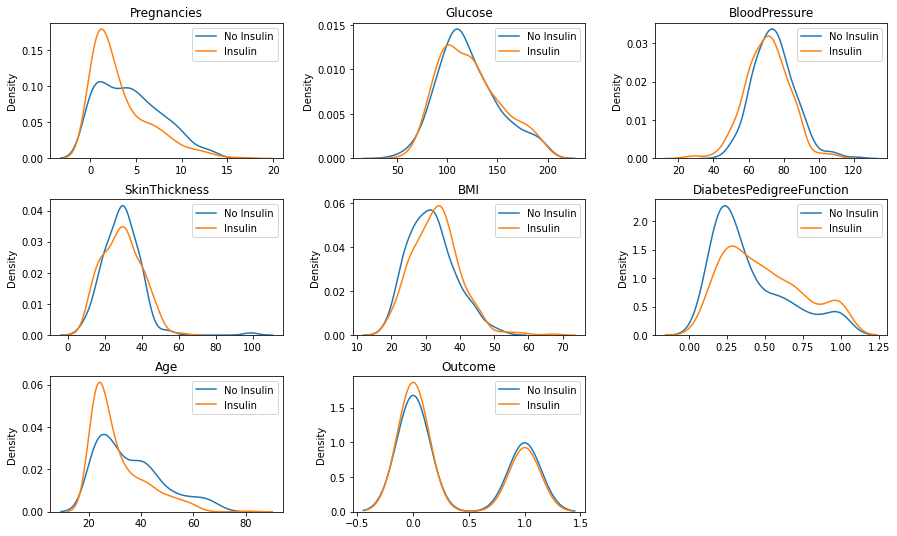

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(15,9))

sns.kdeplot(diabetes[ no_insulin ].Pregnancies, label='No Insulin', ax = axs[0,0])
sns.kdeplot(diabetes[ ~no_insulin ].Pregnancies, label='Insulin', ax = axs[0,0] )
axs[0,0].set_title('Pregnancies')
axs[0,0].legend()
axs[0,0].xaxis.label.set_visible(False)

sns.kdeplot(diabetes[ (no_insulin) ].Glucose, label='No Insulin', ax = axs[0,1])
sns.kdeplot(diabetes[ (~no_insulin) ].Glucose, label='Insulin', ax = axs[0,1])
axs[0,1].set_title('Glucose')
axs[0,1].legend()
axs[0,1].xaxis.label.set_visible(False)

sns.kdeplot(diabetes[ (no_insulin) & (~no_bp) ].BloodPressure, label='No Insulin', ax = axs[0,2])
sns.kdeplot(diabetes[ (~no_insulin) & (~no_bp) ].BloodPressure, label='Insulin', ax = axs[0,2])
axs[0,2].set_title('BloodPressure')
axs[0,2].legend()
axs[0,2].xaxis.label.set_visible(False)

sns.kdeplot(diabetes[ (~no_skin) & (no_insulin) ].SkinThickness, label='No Insulin', ax = axs[1,0])
sns.kdeplot(diabetes[ (~no_skin) & (~no_insulin) ].SkinThickness, label='Insulin', ax = axs[1,0])
axs[1,0].set_title('SkinThickness')
axs[1,0].legend()
axs[1,0].xaxis.label.set_visible(False)

sns.kdeplot(diabetes[ no_insulin ].BMI, label='No Insulin', ax = axs[1,1])
sns.kdeplot(diabetes[ ~no_insulin ].BMI, label='Insulin', ax = axs[1,1])
axs[1,1].set_title('BMI')
axs[1,1].legend()
axs[1,1].xaxis.label.set_visible(False)

sns.kdeplot(diabetes[ no_insulin ].DiabetesPedigreeFunction, label='No Insulin', ax = axs[1,2])
sns.kdeplot(diabetes[ ~no_insulin ].DiabetesPedigreeFunction, label='Insulin', ax = axs[1,2])
axs[1,2].set_title('DiabetesPedigreeFunction')
axs[1,2].legend()
axs[1,2].xaxis.label.set_visible(False)

sns.kdeplot(diabetes[ no_insulin ].Age, label='No Insulin', ax = axs[2,0])
sns.kdeplot(diabetes[ ~no_insulin ].Age, label='Insulin', ax = axs[2,0])
axs[2,0].set_title('Age')
axs[2,0].legend()
axs[2,0].xaxis.label.set_visible(False)

sns.kdeplot(diabetes[ no_insulin ].Outcome, label='No Insulin', ax = axs[2,1])
sns.kdeplot(diabetes[ ~no_insulin ].Outcome, label='Insulin', ax = axs[2,1])
axs[2,1].set_title('Outcome')
axs[2,1].legend()
axs[2,1].xaxis.label.set_visible(False)

axs[2,2].remove()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)

Some key takeaways from the plot above: 
* There are not much of a differences between the distributions of `SkinThickness` of zeros and those that are not for these columns: `Glucose`, `SkinThickness`, `BMI`, and `Outcome`.
* The distribution of `Pregnancies` is more dense at around 0 for people with `Insulin`.
* The distribution of `DiabetesPedigreeFunction` is more dense at around 0.25 for people without
`Insulin`.
* People with `Insulin` data available is more likely to have `Age` around 20.

We replaced the missing values in the `Insulin` column with existing values using the random imputation. 

In [ ]:
diabetes['Insulin']=diabetes['Insulin'].replace(0, random.choice(diabetes[diabetes.SkinThickness != 0 ]["Insulin"]))

### Determine the dependency in missingness between `SkinThickness`, `Insulin`, and `BloodPressure`

First, we try to determine if the missingness of `SkinThickness` and `Insulin` are independent. 
Then, we will decide if the missingness of `BloodPressure` and `Insulin` are independent.

In [ ]:
diabetes['skin_missing'] = np.where(diabetes['SkinThickness'] == 0, 0, 1)
diabetes['insulin_missing'] = np.where(diabetes['Insulin'] == 0, 0, 1)
diabetes['BloodPressure_missing'] = np.where(diabetes['BloodPressure'] == 0, 0, 1)
table = pd.crosstab(diabetes['skin_missing'], diabetes['insulin_missing'], margins=True)
table1 = pd.crosstab(diabetes['BloodPressure_missing'], diabetes['insulin_missing'], margins=True)

In [ ]:
stat, p, dof, expected = stats.chi2_contingency(table)
alpha = 0.05
# null hypothesis: the missingness of skinthickness and insulin are independent
if p < alpha:
    print('Reject H0, the missingness of SkinThickness column and Insulin column are dependent')
else:
    print('Fail to Reject H0, independent')

stat, p, dof, expected = stats.chi2_contingency(table1)
alpha = 0.05
# null hypothesis: the missingness of bloodpressure and insulin are independent
if p < alpha:
    print('Reject H0, the missingness of BloodPressure column and Insulin column are dependent') 
else:
    print('Fail to Reject H0, independent')

Fail to Reject H0, independent
Fail to Reject H0, independent


According to the result of the statistical test, the missingness of `SkinThickness`, `Insulin`, 
and `BloodPressure` are dependent, 
which means that it's highly likely that records with zero `SkinThickness` also 
has `Insulin` as zero and `BloodPressure` as zero. 
To intepret this result, it's possible that people are getting their `SkinThickness`, `Insulin`,
and `BloodPressure` measured at the same time. 

### Bivariate analysis on the distribution of `Outcome` for different `Pregnancies` 
We want to look into the probability mass function (pmf) of the `Pregnancies` column before 
and after censoring to make sure we account for the possible extreme cases from the dataset.

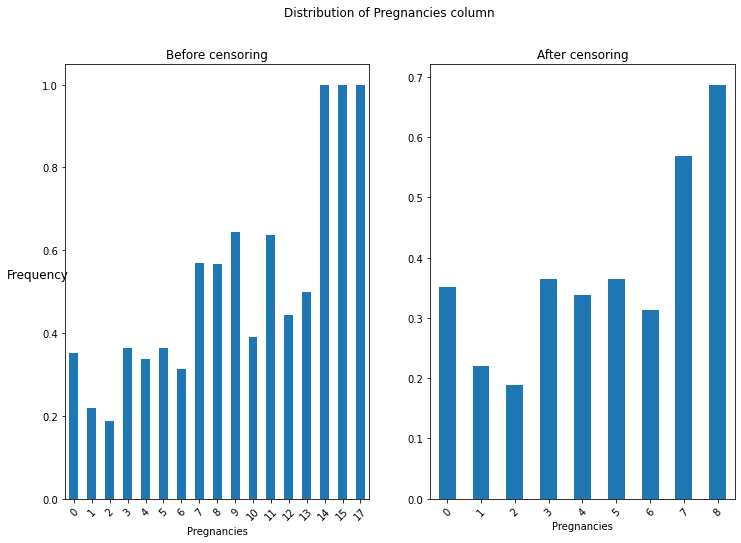

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
fig.suptitle('Distribution of Pregnancies column')
df = pd.DataFrame(diabetes.groupby('Pregnancies')['Outcome'].mean())
df.plot(kind='bar', legend=None, ax=axes[0])
plt.xticks(rotation=45)
df1 = pd.DataFrame(diabetes.groupby('Pregnancies')['Outcome'].mean())
df1.loc[8] = df1[df1.index >= 8].Outcome.mean()
df1.drop(index=[9,10,11,12,13,14,15,17],inplace=True)
df1.plot(kind='bar', legend=None, ax=axes[1])
plt.xticks(rotation=45)
cols = ['Before censoring', 'After censoring']
rows = ['Frequency']

for ax, col in zip(axes, cols):
    ax.set_title(col)
for ax, row in zip(axes, rows):
    ax.set_ylabel(row, rotation=0, size='large')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

Based on the left distribution above, we can see that there is some abnormalities that can't be
explained by `Pregnancies` column alone. This is because there is a drop from not pregnant at all
to get pregnant 1 or 2 times and follow by a significant rise at 3 and 7. Then, a drop at 10 followed
by a spike at 11. Lastly, people who are pregnant more than 12 times all have diabetes. 

We cencored `Pregnancies` at 8 to be the average of mean of `Pregnancies` that are greater than
or equal to 8. This way, it not only reflects the high possibility to have diabetes if the person
was pregnant more than 8 times, but also maintains the overall distribution of the 'Pregnancies'
column.

In [ ]:
X = diabetes[['Pregnancies']]
X = sm.add_constant(X)
y = diabetes['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

log_reg = sm.Logit(y_train, X_train).fit() 
log_reg.summary()
# print(np.sum(abs(log_reg.resid_pearson)))

Optimization terminated successfully.
         Current function value: 0.632123
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Outcome   No. Observations:                  503
Model:                          Logit   Df Residuals:                      501
Method:                           MLE   Df Model:                            1
Date:                Sat, 06 Mar 2021   Pseudo R-squ.:                 0.03740
Time:                        03:11:36   Log-Likelihood:                -317.96
converged:                       True   LL-Null:                       -330.31
Covariance Type:            nonrobust   LLR p-value:                 6.666e-07
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.1039      0.151     -7.325      0.000      -1.399      -0.808
Pregnancies     0.1387      0.029      4.853      0.000       0.083       0.195
===============================================================================
"""

Since `Pregnancies` is statistically significant (with p-value less than 0.05), we choose to 
put this column into our model.

### Bivariate analysis on the distribution of `Outcome` for different `Glucose` 
We want to see if there is significant difference in `Outcome` between different level of `Glucose`.
But, first thing first, we have to cut `Glucose` into bins.

One thing to note is that we didn't use medical terms for each bin because that might result in
unevenly distributed bins since most of the records in this dataset have diabetes. We think
it's more important to have each bin containing the same number of people. As a result, 
we just used integer to label each group.

Text(0.5, 1.0, 'Mean Outcome of Glucose levels')

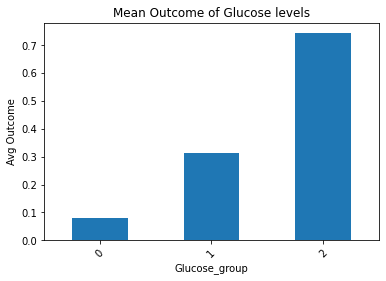

In [ ]:
diabetes['Glucose_group'] = pd.cut(diabetes['Glucose'], bins = 3, labels=False)
diabetes.groupby('Glucose_group').Outcome.mean().plot(kind = 'bar')
plt.xticks(rotation = 45)
plt.ylabel('Avg Outcome')
plt.title('Mean Outcome of Glucose levels')

Based on the plot above, people with high glucose level are much more likely to be
classified as people who have diabetes.

We want to compare the model performance between the original `Glucose` column and the one
we cut into bins and determine if we are going to put this feature into the final model.
And if we are, we have to choose the one with better performance, comparing the r-square and the
residuals.

In [ ]:
X = diabetes[['Glucose']]
X = sm.add_constant(X)
y = diabetes['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

log_reg = sm.Logit(y_train, X_train).fit() 
print(log_reg.summary())
print(np.sum(abs(log_reg.resid_pearson)))

Optimization terminated successfully.
         Current function value: 0.528622
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  503
Model:                          Logit   Df Residuals:                      501
Method:                           MLE   Df Model:                            1
Date:                Sat, 06 Mar 2021   Pseudo R-squ.:                  0.1950
Time:                        03:11:36   Log-Likelihood:                -265.90
converged:                       True   LL-Null:                       -330.31
Covariance Type:            nonrobust   LLR p-value:                 7.381e-30
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.4502      0.520    -10.473      0.000      -6.470      -4.430
Glucose        0.0394      0.

In [ ]:
X = diabetes[['Glucose_group']]
X = sm.add_constant(X)
y = diabetes['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

log_reg = sm.Logit(y_train, X_train).fit() 
print(log_reg.summary())
print(np.sum(abs(log_reg.resid_pearson)))

Optimization terminated successfully.
         Current function value: 0.547711
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  503
Model:                          Logit   Df Residuals:                      501
Method:                           MLE   Df Model:                            1
Date:                Sat, 06 Mar 2021   Pseudo R-squ.:                  0.1659
Time:                        03:11:36   Log-Likelihood:                -275.50
converged:                       True   LL-Null:                       -330.31
Covariance Type:            nonrobust   LLR p-value:                 1.182e-25
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -2.4258      0.243     -9.988      0.000      -2.902      -1.950
Glucose_group     1.

Both `Glucose` and `Glucose_group` are statistically significant (with p-value less than 0.05).
Since `Glucose` has a higher r-square is higher and lower residual, we choose to `Glucose` into our model.

### Bivariate analysis on the distribution of `BloodPressure ` column based on `Outcome`

We want to see if there is significant difference in `Outcome` between different level of `BloodPressure`.
But, first thing first, we have to cut `BloodPressure` into bins.

Text(0.5, 1.0, 'Mean Outcome of BloodPressure levels')

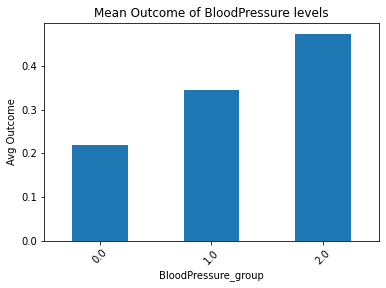

In [ ]:
diabetes['BloodPressure_group'] = pd.cut(diabetes[ ~no_bp ].BloodPressure, bins = 3, labels=False)
diabetes.groupby('BloodPressure_group').Outcome.mean().plot(kind = 'bar')
plt.xticks(rotation=45)
plt.ylabel('Avg Outcome')
plt.title('Mean Outcome of BloodPressure levels')

In [ ]:
diabetes.BloodPressure_group.value_counts()

1.0    601
0.0     64
2.0     59
Name: BloodPressure_group, dtype: int64

Based on the information of number of records in each category, we can see that the number of people
being classified into each cateogory is much different, which is the possible reason why `BloodPressure_group`
have an unexpected distribution. It's also possible that blood pressure does not contribute
much to being diagnosed with diabetes. 


In [ ]:
X = diabetes[['BloodPressure']]
X = sm.add_constant(X)
y = diabetes['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

log_reg = sm.Logit(y_train, X_train).fit() 
print(log_reg.summary())
print(np.sum(abs(log_reg.resid_pearson)))

Optimization terminated successfully.
         Current function value: 0.645775
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  503
Model:                          Logit   Df Residuals:                      501
Method:                           MLE   Df Model:                            1
Date:                Sat, 06 Mar 2021   Pseudo R-squ.:                 0.01661
Time:                        03:11:37   Log-Likelihood:                -324.82
converged:                       True   LL-Null:                       -330.31
Covariance Type:            nonrobust   LLR p-value:                 0.0009230
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -2.4642      0.600     -4.108      0.000      -3.640      -1.288
BloodPressure     0.

In [ ]:
diabetes['BloodPressure_group'] = pd.cut(diabetes['BloodPressure'], bins = 3, labels=False)
X = diabetes[['BloodPressure_group']]
X = sm.add_constant(X)
y = diabetes['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

log_reg = sm.Logit(y_train, X_train).fit() 
print(log_reg.summary())
print(np.sum(abs(log_reg.resid_pearson)))

Optimization terminated successfully.
         Current function value: 0.653874
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  503
Model:                          Logit   Df Residuals:                      501
Method:                           MLE   Df Model:                            1
Date:                Sat, 06 Mar 2021   Pseudo R-squ.:                0.004281
Time:                        03:11:37   Log-Likelihood:                -328.90
converged:                       True   LL-Null:                       -330.31
Covariance Type:            nonrobust   LLR p-value:                   0.09261
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.9680      0.269     -3.600      0.000      -1.495      -0.441
Bl

Both `BloodPressure` and `new_BloodPressure_group` are both statistically significant (lower than 0.05). We chose the original `BloodPressure` column because it has higher r-square and
lower p-value.

### Bivariate analysis between `SkinThickness` and `Outcome`
We want to investigate if there is significant difference in `Outcome` between different level 
of `SkinThickness`.

Text(0.5, 1.0, 'Mean Outcome of SkinThickness levels')

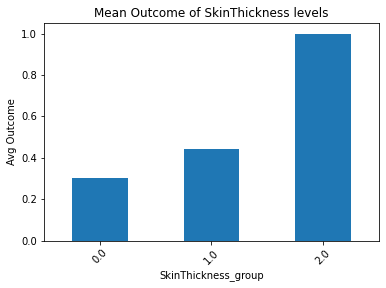

In [ ]:
diabetes['SkinThickness_group'] = pd.cut(diabetes[ ~no_skin ].SkinThickness, bins = 3, labels=False)
diabetes.groupby('SkinThickness_group').Outcome.mean().plot(kind = 'bar')
plt.xticks(rotation = 45)
plt.ylabel('Avg Outcome')
plt.title('Mean Outcome of SkinThickness levels')

According to the plot above, people with thicker skin are much more likely to be
classified as people who have diabetes.

In [ ]:
X = diabetes[['SkinThickness']]
X = sm.add_constant(X)
y = diabetes['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

log_reg = sm.Logit(y_train, X_train).fit() 
log_reg.summary()
# print(np.sum(abs(log_reg.resid_pearson)))

Optimization terminated successfully.
         Current function value: 0.634580
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Outcome   No. Observations:                  503
Model:                          Logit   Df Residuals:                      501
Method:                           MLE   Df Model:                            1
Date:                Sat, 06 Mar 2021   Pseudo R-squ.:                 0.03366
Time:                        03:11:37   Log-Likelihood:                -319.19
converged:                       True   LL-Null:                       -330.31
Covariance Type:            nonrobust   LLR p-value:                 2.409e-06
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.8858      0.314     -6.009      0.000      -2.501      -1.271
SkinThickness     0.0376      0.008      4.552      0.000       0.021       0.054
=================================================================================
"""

In [ ]:
diabetes['SkinThickness_group'] = pd.cut(diabetes['SkinThickness'], bins = 3, labels=False)
X = diabetes[['SkinThickness_group']]
X = sm.add_constant(X)
y = diabetes['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

log_reg = sm.Logit(y_train, X_train).fit() 
log_reg.summary()
# print(np.sum(abs(log_reg.resid_pearson)))

Optimization terminated successfully.
         Current function value: 0.649267
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Outcome   No. Observations:                  503
Model:                          Logit   Df Residuals:                      501
Method:                           MLE   Df Model:                            1
Date:                Sat, 06 Mar 2021   Pseudo R-squ.:                 0.01130
Time:                        03:11:37   Log-Likelihood:                -326.58
converged:                       True   LL-Null:                       -330.31
Covariance Type:            nonrobust   LLR p-value:                  0.006298
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.7813      0.128     -6.102      0.000      -1.032      -0.530
SkinThickness_group     0.5048      0.185      2.726      0.006       0.142       0.868
=======================================================================================
"""

Only `SkinThickness` is  statistically significant (lower than 0.05). We chose the original `SkinThickness` column.

### Bivariate analysis on the distribution of `Insulin` column based on `Outcome`
We want to investigate if there is significant difference in `Outcome` between different level 
of `Insulin` amoung records that have this data available.

Text(0.5, 1.0, 'Mean Outcome of Insulin levels')

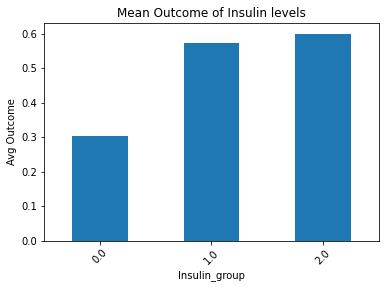

In [ ]:
diabetes['Insulin_group'] = pd.cut(diabetes[~no_insulin].Insulin, bins = 3, labels=False)
diabetes.groupby('Insulin_group').Outcome.mean().plot(kind = 'bar')
plt.xticks(rotation = 45)
plt.ylabel('Avg Outcome')
plt.title('Mean Outcome of Insulin levels')

Based on the plot above, people with normal to high insulin level are almost twice as likely to be
classified as people with diabetes.

In [ ]:
X = diabetes[['Insulin']]
X = sm.add_constant(X)
y = diabetes['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

log_reg = sm.Logit(y_train, X_train).fit() 
print(log_reg.summary())
print(np.sum(abs(log_reg.resid_pearson)))

Optimization terminated successfully.
         Current function value: 0.643555
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  503
Model:                          Logit   Df Residuals:                      501
Method:                           MLE   Df Model:                            1
Date:                Sat, 06 Mar 2021   Pseudo R-squ.:                 0.02000
Time:                        03:11:37   Log-Likelihood:                -323.71
converged:                       True   LL-Null:                       -330.31
Covariance Type:            nonrobust   LLR p-value:                 0.0002785
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9006      0.137     -6.572      0.000      -1.169      -0.632
Insulin        0.0035      0.

In [ ]:
diabetes['Insulin_group'] = pd.cut(diabetes['Insulin'], bins = 3, labels=False)
X = diabetes[['Insulin_group']]
X = sm.add_constant(X)
y = diabetes['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

log_reg = sm.Logit(y_train, X_train).fit() 
print(log_reg.summary())
print(np.sum(abs(log_reg.resid_pearson)))

Optimization terminated successfully.
         Current function value: 0.644337
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  503
Model:                          Logit   Df Residuals:                      501
Method:                           MLE   Df Model:                            1
Date:                Sat, 06 Mar 2021   Pseudo R-squ.:                 0.01880
Time:                        03:11:37   Log-Likelihood:                -324.10
converged:                       True   LL-Null:                       -330.31
Covariance Type:            nonrobust   LLR p-value:                 0.0004242
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.6219      0.096     -6.503      0.000      -0.809      -0.434
Insulin_group     1.

There is not much of a different between the residuals for these two models. As a result, we chose the one we cut into bins.

### Bivariate analysis on the distribution of `BMI` column based on `Outcome`
We want to look into if there is significant difference in `Outcome` between different level 
of `BMI`.

Text(0.5, 1.0, 'Mean Outcome of BMI levels')

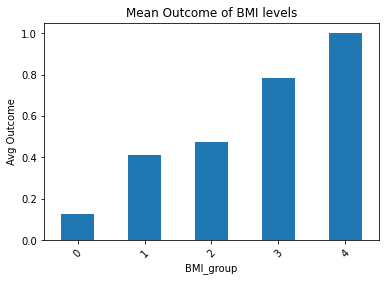

In [ ]:
diabetes['BMI_group'] = pd.cut(diabetes['BMI'], bins = 5, labels=False)
diabetes.groupby('BMI_group').Outcome.mean().plot(kind = 'bar')
plt.xticks(rotation = 45)
plt.ylabel('Avg Outcome')
plt.title('Mean Outcome of BMI levels')

In [ ]:
X = diabetes[['BMI']]
X = sm.add_constant(X)
y = diabetes['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

log_reg = sm.Logit(y_train, X_train).fit() 
print(log_reg.summary())
print(np.sum(abs(log_reg.resid_pearson)))

Optimization terminated successfully.
         Current function value: 0.613122
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  503
Model:                          Logit   Df Residuals:                      501
Method:                           MLE   Df Model:                            1
Date:                Sat, 06 Mar 2021   Pseudo R-squ.:                 0.06634
Time:                        03:11:38   Log-Likelihood:                -308.40
converged:                       True   LL-Null:                       -330.31
Covariance Type:            nonrobust   LLR p-value:                 3.591e-11
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.6533      0.514     -7.102      0.000      -4.662      -2.645
BMI            0.0935      0.

In [ ]:
X = diabetes[['BMI_group']]
X = sm.add_constant(X)
y = diabetes['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

log_reg = sm.Logit(y_train, X_train).fit() 
print(log_reg.summary())
print(np.sum(abs(log_reg.resid_pearson)))

Optimization terminated successfully.
         Current function value: 0.617307
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  503
Model:                          Logit   Df Residuals:                      501
Method:                           MLE   Df Model:                            1
Date:                Sat, 06 Mar 2021   Pseudo R-squ.:                 0.05996
Time:                        03:11:38   Log-Likelihood:                -310.51
converged:                       True   LL-Null:                       -330.31
Covariance Type:            nonrobust   LLR p-value:                 3.094e-10
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3766      0.173     -7.961      0.000      -1.716      -1.038
BMI_group      0.8108      0.

Both `BMI` and `BMI_group` is statistically significant (lower than 0.05). 
Since there is not much of a different in residual and r-square. We decide to use the one we cut
into bins as a feature in our model.

### Bivariate analysis on the distribution of the `DiabetesPedigreeFunction` column based on `Outcome`
We want to explore if there is significant difference in `Outcome` between different level 
of `DiabetesPedigreeFunction`.

Text(0.5, 1.0, 'Mean Outcome of DiabetesPedigreeFunction levels')

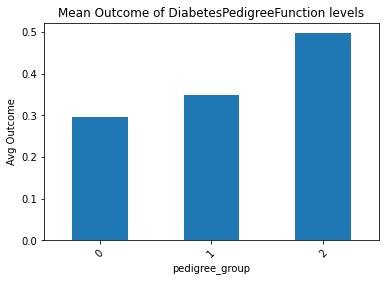

In [ ]:
diabetes['pedigree_group'] = pd.cut(diabetes['DiabetesPedigreeFunction'], bins = 3, labels=False)
diabetes.groupby('pedigree_group').Outcome.mean().plot(kind = 'bar')
plt.xticks(rotation = 45)
plt.ylabel('Avg Outcome')
plt.title('Mean Outcome of DiabetesPedigreeFunction levels')

According to the plot above, people who come from a family history that have a record of diabetes
are more likely to have diabetes. 

In [ ]:
X = diabetes[['DiabetesPedigreeFunction']]
X = sm.add_constant(X)
y = diabetes['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

log_reg = sm.Logit(y_train, X_train).fit() 
print(log_reg.summary())
print(np.sum(abs(log_reg.resid_pearson)))

Optimization terminated successfully.
         Current function value: 0.639586
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  503
Model:                          Logit   Df Residuals:                      501
Method:                           MLE   Df Model:                            1
Date:                Sat, 06 Mar 2021   Pseudo R-squ.:                 0.02604
Time:                        03:11:38   Log-Likelihood:                -321.71
converged:                       True   LL-Null:                       -330.31
Covariance Type:            nonrobust   LLR p-value:                 3.362e-05
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -1.2221      0.191     -6.383      0.000      -1.597

In [ ]:
X = diabetes[['pedigree_group']]
X = sm.add_constant(X)
y = diabetes['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

log_reg = sm.Logit(y_train, X_train).fit() 
print(log_reg.summary())
print(np.sum(abs(log_reg.resid_pearson)))

Optimization terminated successfully.
         Current function value: 0.645106
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  503
Model:                          Logit   Df Residuals:                      501
Method:                           MLE   Df Model:                            1
Date:                Sat, 06 Mar 2021   Pseudo R-squ.:                 0.01763
Time:                        03:11:38   Log-Likelihood:                -324.49
converged:                       True   LL-Null:                       -330.31
Covariance Type:            nonrobust   LLR p-value:                 0.0006425
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.8302      0.127     -6.552      0.000      -1.078      -0.582
pedigree_group   

Both `DiabetesPedigreeFunction` and `pedigree_group` is statistically significant (lower than 0.05). 
Since there is not much of a different in residual and r-square. We decide to use the one we cut
into bins as a feature in our model.

### Bivariate analysis on the distribution of the `Age` column based on `Outcome`
We want to investigate if there is significant difference in `Outcome` between different level 
of `Age`.

Text(0.5, 1.0, 'Mean Outcome of Age Groups')

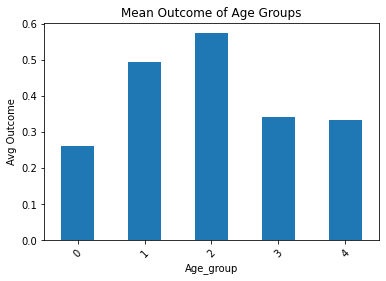

In [ ]:
diabetes['Age_group'] = pd.cut(diabetes['Age'], bins = 5, labels=False)
diabetes.groupby('Age_group').Outcome.mean().plot(kind = 'bar')
plt.xticks(rotation = 45)
plt.ylabel('Avg Outcome')
plt.title('Mean Outcome of Age Groups')

In [ ]:
diabetes.Age_group.value_counts()

0    462
1    174
2     75
3     38
4      3
Name: Age_group, dtype: int64

As we can see on the plot above, people that are classified as young adult and middle age are more
likely to have diabetes compared to other groups. This is the result of unevenly distributed 
people in these age groups.

Since every feature column is ordinal and the means of the outcome of those columns is linear 
(except `Age`), we decide to use labels that generated in the previous analysis.

We have to use a different encoding method, one-hot encoding, to transform the `Age` column.

In [ ]:
df = pd.get_dummies(diabetes.Age_group, prefix='Age')
diabetes = pd.concat([df, diabetes], axis=1)

In [ ]:
X = diabetes[['Age_1', 'Age_2', 'Age_3', 'Age_4']]
X = sm.add_constant(X)
y = diabetes['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

log_reg = sm.Logit(y_train, X_train).fit() 
print(log_reg.summary())
print(np.sum(abs(log_reg.resid_pearson))) #the raw residual divided by the square root of the variance function

Optimization terminated successfully.
         Current function value: 0.622670
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  503
Model:                          Logit   Df Residuals:                      498
Method:                           MLE   Df Model:                            4
Date:                Sat, 06 Mar 2021   Pseudo R-squ.:                 0.05180
Time:                        03:11:38   Log-Likelihood:                -313.20
converged:                       True   LL-Null:                       -330.31
Covariance Type:            nonrobust   LLR p-value:                 6.717e-07
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9600      0.128     -7.527      0.000      -1.210      -0.710
Age_1          0.9768      0.

As you saw on the chart of mean `Outcome` of `Age` group and the model with the encoded categorical `Age` column, `Age` doesn't really play into determining whether the person
has diabetes or not, especially for the `Age_3` and `Age_4` group. As a result, we decide to leave it out.  

### Key takeaways from bivariate analysis
After comparing the **coefficient of determinant** (the proportion of the variance in the each column that can be explained by the independent variable) and residual between the original columns (numerical variables) and the encoded columns, here is the list of features we decided to put into our model to explain and predict `Outcome`:
* `Pregnancies` - significant and positive correlated
* `Glucose` - significant and positive correlated
* `BloodPressure` - significant and positive correlated
* `SkinThickness` - significant and positive correlated
* `Insulin_group` - significant and positive correlated
* `BMI_group` - significant and positive correlated
* `Pedigree_group` - significant and positive correlated

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=fd4a356b-76ac-4ad6-9eb0-790688a80ec2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>